# Code for causality section in Technical validation for the paper: A Multivariate Earth System Data Cube for Wildfire Dynamics

## This notebook is about causal discovery of the effect between ocean climate indices, meteorolical variables and burned areas, by using the tigramite library (https://tocsy.pik-potsdam.de/tigramite.php)

In [1]:
## import all libraries needed
import numpy as np
import xarray as xr
import pandas as pd
import datetime as datetime
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

## Tigramite modules 

from tigramite.pcmci import PCMCI
import tigramite.data_processing as pp
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite import plotting as tp



/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))


## Access the cube 

In [2]:
## Access the SeasFire datacube version 3 from your local path or via google drive (check instructions here: https://github.com/SeasFire) 
path=Path.home() / 'jh-shared/ilektra/SeasFire/SeasFireCube_v3.zarr'
ds=xr.open_zarr(path)

## Create Monthly anomalies dataset for making the data non stationary (prerequiside for pcmci)

In [3]:
## Define the variables you want to test from the cube and then how you will resample them to monthly 
## Resample sum
sum_var={'gwis_ba'}
## Resample mean
mean_vars={'ndvi', 't2m_mean', 'vpd', 'tp','oci_nao','oci_ao','oci_nina34_anom'}
## static variables
static_vars={'gfed_region','biomes'}
     

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for var in sum_var:              
        resampled1=ds[sum_var].resample(time='1M').sum()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for var in mean_vars:              
        resampled=ds[mean_vars].resample(time='1M').mean()

In [5]:
resample=resampled.merge(resampled1)

In [6]:

average_monthly =resample.groupby('time.month').mean(dim='time')
group=resample.groupby('time.month') 
# Calculate the burnt area anomaly for each month, for each year
anomalies =group - average_monthly

/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]


In [8]:
## add the static variables as well

for var in static_vars:              
    static=ds[static_vars]
    
anomalies=anomalies.merge(static)


In [9]:
anomalies

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 252)
Coordinates:
  * latitude         (latitude) float64 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude        (longitude) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time             (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2021-12-31
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Data variables:
    vpd              (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    oci_nao          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    oci_nina34_anom  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t2m_mean         (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ndvi             (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    tp               (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    oci_ao           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    gwis_ba          (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    gfed_region      (latitude, longitude) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    biomes           (latitude, longitude) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>

## Make datasets for each biome you want to test

## Case 1: Euro-Mediterranean 
## gfed region==6.0 (Europe)
## biome=3.0 (Medditerranean forests)

In [10]:
eur=anomalies.where(anomalies.gfed_region==6.0)

/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/home/jupyter-electra/.virtualenvs/myenv/lib/python3.8/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


In [15]:
#slice the dataset 
med=eur.sel(latitude=slice(70,25),longitude=slice(-13,45))
med=med.where(med.biomes==3.0)

(-13.0, 45.0, 25.0, 70.0)

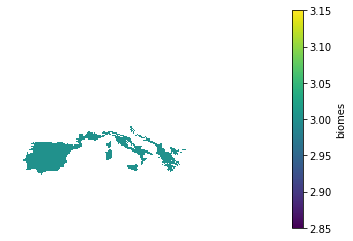

In [16]:
#view the area
med.biomes.plot()
plt.axis('off')

In [17]:
def extract_data(dataset, start, end):
    
    ## burned area
    ba = dataset.gwis_ba.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    
    #meteo
    tot_pr = dataset.tp.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    temp= dataset.t2m_mean.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    vp= dataset.vpd.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    
    # ocis
    nao=dataset.oci_nao.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    ao=dataset.oci_ao.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    nino=dataset.oci_nina34_anom.sel(time=slice(start, end)).coarsen(longitude=len(dataset.gwis_ba.longitude.values),latitude=len(dataset.gwis_ba.latitude.values),boundary='pad').mean().fillna(-9999).values
    
    return ba, tot_pr,temp,vp,nao,ao,nino

In [18]:
## Burned areas are until 2020 so use data until then and fill NaN with a value
## we are testing 19 years monthly dataset

start='2001'
end='2019'


In [19]:
ba, tot_pr,temp,vp,nao,ao,nino = extract_data(med, start, end)

In [20]:
ba=ba.flatten()
tot_pr=tot_pr.flatten()
temp=temp.flatten()
vp=vp.flatten()
nao=nao.flatten()
ao=ao.flatten()
nino=nino.flatten()

df_med = pd.DataFrame({'Burned_areas': ba, 'precipitation': tot_pr,'max_temp': temp, 'vpd':vp,'nao':nao,'ao':ao,'nino':nino})


## Now lets run PCMCI

## Create a sequence of ocis -> affect -> meteo -> affect -> burned areas

In [21]:
def run_and_plot(dataframe, cond_ind_test,title,save):   
    #0->   ba
    #1-> temp
    #2-> tot_pr
    #3-> vp
    #4-> nao 
    #5-> ao 
    #6 -> nino 
    
    dict1={0: [(0,0),(0,-1),(0,-2),(0,-3),(0,-4),(0,-5),(0,-6),  #ba
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      1: [  #temp
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      2:[  #tot_pr
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      3: [  #vp
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      4: [  #nao
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      5: [ #ao
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      6: [  #nino
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)] } 

    # Create and run Multidata-PCMCIplus
    pcmci = PCMCI(dataframe = dataframe, cond_ind_test = cond_ind_test)
    results = pcmci.run_pcmci(tau_max = 6, pc_alpha = 0.05,selected_links=dict1)

    
    tp.plot_graph(graph=results['graph'], val_matrix=results['val_matrix'],arrowhead_size=25,curved_radius=0.3,arrow_linewidth=8.0, var_names=var_names,show_colorbar=True,figsize=(12,10),
                  node_label_size=20,link_label_fontsize=25)

    #plt.title(title,fontsize=20)#,loc='center',x=1.1,y=7.0, pad=210)
    plt.savefig(Path.home() / save,dpi=500,bbox_inches='tight')
    plt.show()

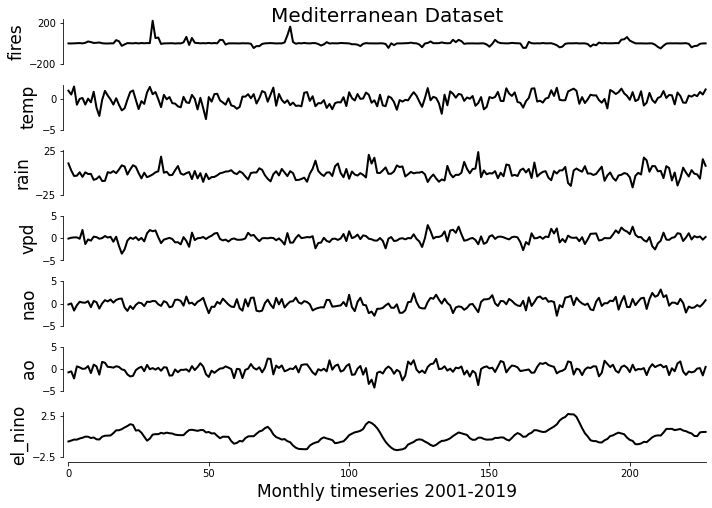

In [23]:
T = len(ba) ## timeseries
N = 7   ## variables

# Initialize Gaussian noise
data = np.random.randn(T, N) 



# Consider a time series coming from the following data generating process
for t in range(T):  
        data[t,0]=ba[t]  
        data[t,1]=temp[t]
        data[t,2]=tot_pr[t]
        data[t,3]=vp[t]
        data[t,4]=nao[t]
        data[t,5]=ao[t]
        data[t,6]=nino[t]
   
        
var_names= ['fires','temp','rain','vpd','nao','ao','el_nino'] ## name the variables 
        
        
dataframe = pp.DataFrame(data,var_names=var_names,missing_flag=-9999)
cond_ind_test = ParCorr()

tp.plot_timeseries(dataframe, figsize=(10,7),label_fontsize=17,data_linewidth=2.0, time_label='Monthly timeseries 2001-2019')
plt.title('Mediterranean Dataset',loc='center',y=9.6,fontsize=20);

plt.savefig('timeseries_Med_biome.png',dpi=500, bbox_inches='tight')

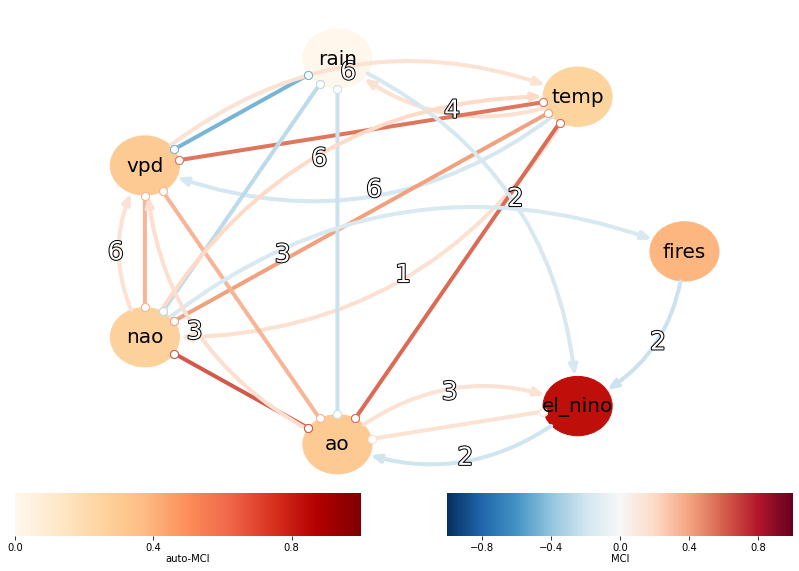

In [65]:
run_and_plot(dataframe = dataframe, cond_ind_test = ParCorr(significance='analytic'),title="Mediterranean biome",save='causal_graph_med_biome.png')

## For illustration reasons the figures in the paper were reconstructed via the significant links and not exported directly via tigramite.plot 

In [25]:
    dict1={0: [(0,0),(0,-1),(0,-2),(0,-3),(0,-4),(0,-5),(0,-6),  #ba
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      1: [  #temp
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      2:[  #tot_pr
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      3: [  #vp
           (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
           (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
           (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      4: [  #nao
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      5: [ #ao
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
      6: [  #nino
           (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
           (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
           (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)] } 

    # Create and run Multidata-PCMCIplus
    pcmci = PCMCI(dataframe = dataframe, cond_ind_test = cond_ind_test)
    results = pcmci.run_pcmci(tau_max = 6, pc_alpha = 0.05,selected_links=dict1)
    

# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=6, fdr_method='fdr_bh')
l=pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'])
       # alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable fires has 4 link(s):
        (fires -1): pval = 0.00002 | val =  0.292
        (vpd -1): pval = 0.00063 | val =  0.233
        (vpd  0): pval = 0.00856 | val =  0.180
        (el_nino -6): pval = 0.01480 | val = -0.167

    Variable temp has 5 link(s):
        (vpd  0): pval = 0.00000 | val =  0.604
        (rain  0): pval = 0.00002 | val = -0.288
        (temp -1): pval = 0.00025 | val =  0.249
        (vpd -6): pval = 0.00120 | val =  0.221
        (el_nino -1): pval = 0.01133 | val =  0.174

    Variable rain has 7 link(s):
        (vpd  0): pval = 0.00000 | val = -0.563
        (ao  0): pval = 0.00000 | val = -0.453
        (temp  0): pval = 0.00002 | val = -0.288
        (rain -1): pval = 0.00022 | val =  0.250
        (el_nino -2): pval = 0.00234 | val =  0.208
        (nao  0): pval = 0.00637 | val = -0.186
        (nao -6): pval = 0.00759 | val = -0.182

    Variable vpd has 6 link(s):
        (temp  0): pval = 0.00000 | val 

## biome=9.0 (Boreal forests of Europe)

In [26]:
bor=eur.where(anomalies.biomes==9.0)

In [27]:
ba, tot_pr,temp,vp,nao,ao,nino = extract_data(bor, start, end)

In [28]:
ba=ba.flatten()
tot_pr=tot_pr.flatten()
temp=temp.flatten()
vp=vp.flatten()
nao=nao.flatten()
ao=ao.flatten()
nino=nino.flatten()

df_bor = pd.DataFrame({'Burned_areas': ba, 'precipitation': tot_pr,'max_temp': temp, 'vpd':vp,'nao':nao,'ao':ao,'nino':nino})


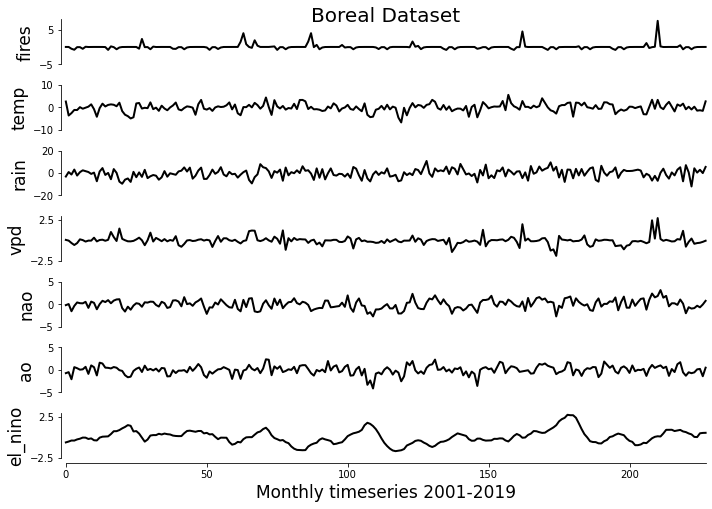

In [29]:
T = len(ba) ## timeseries
N = 7   ## variables

# Initialize Gaussian noise
data = np.random.randn(T, N) 



# Consider a time series coming from the following data generating process
for t in range(T):  
        data[t,0]=ba[t]  
        data[t,1]=temp[t]
        data[t,2]=tot_pr[t]
        data[t,3]=vp[t]
        data[t,4]=nao[t]
        data[t,5]=ao[t]
        data[t,6]=nino[t]
   
        
var_names= ['fires','temp','rain','vpd','nao','ao','el_nino'] ## name the variables 
        
        
dataframe1 = pp.DataFrame(data,var_names=var_names,missing_flag=-9999)
cond_ind_test = ParCorr()
tp.plot_timeseries(dataframe1, figsize=(10,7),label_fontsize=17,data_linewidth=2.0, time_label='Monthly timeseries 2001-2019')
plt.title('Boreal Dataset',loc='center',y=9.6,fontsize=20);

plt.savefig('timeseries_Boreal_biome.png',dpi=500, bbox_inches='tight')

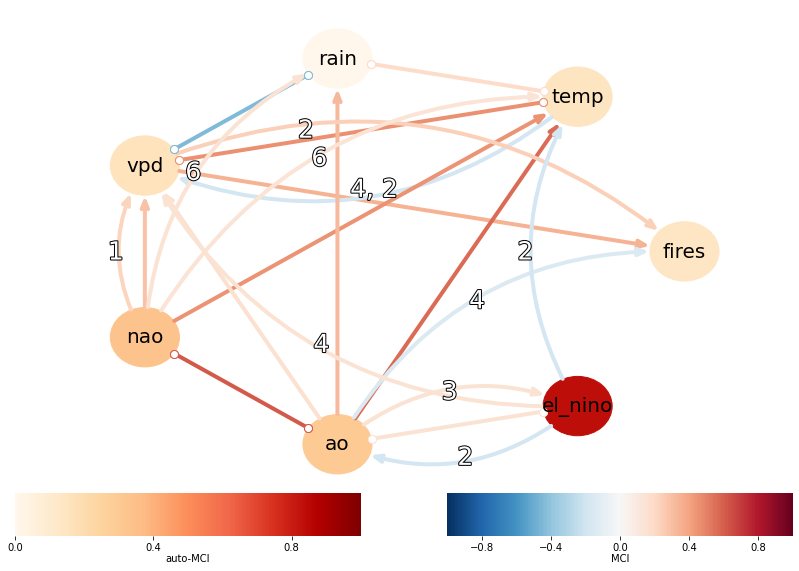

In [30]:
run_and_plot(dataframe = dataframe1, cond_ind_test = ParCorr(significance='analytic'),title="Boreal biome",save='causal_graph_Bor_biome.png')

## Significant links 

In [32]:
dict1={0: [(0,0),(0,-1),(0,-2),(0,-3),(0,-4),(0,-5),(0,-6),  #ba
       (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
       (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
       (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
  1: [  #temp
       (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
       (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
       (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
  2:[  #tot_pr
       (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
       (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
       (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
  3: [  #vp
       (1,0),(1,-1),(1,-2),(1,-3),(1,-4),(1,-5),(1,-6),
       (2,0),(2,-1),(2,-2),(2,-3),(2,-4),(2,-5),(2,-6),
       (3,0),(3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
  4: [  #nao
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
  5: [ #ao
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)],
  6: [  #nino
       (4,0),(4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),
       (5,0),(5,-1),(5,-2),(5,-3),(5,-4),(5,-5),(5,-6),
       (6,0),(6,-1),(6,-2),(6,-3),(6,-4),(6,-5),(6,-6)] } 

# Create and run Multidata-PCMCIplus
pcmci = PCMCI(dataframe = dataframe1, cond_ind_test = cond_ind_test)
results = pcmci.run_pcmci(tau_max = 6, pc_alpha = 0.05,selected_links=dict1)
    

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=6)
l=pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable fires has 4 link(s):
        (vpd  0): pval = 0.00000 | val =  0.351
        (vpd -2): pval = 0.00046 | val =  0.239
        (ao -4): pval = 0.03867 | val = -0.141
        (fires -1): pval = 0.04392 | val =  0.139

    Variable temp has 7 link(s):
        (ao  0): pval = 0.00000 | val =  0.563
        (vpd  0): pval = 0.00000 | val =  0.459
        (nao  0): pval = 0.00000 | val =  0.446
        (rain  0): pval = 0.00435 | val =  0.194
        (el_nino -2): pval = 0.00749 | val = -0.183
        (temp -1): pval = 0.03073 | val =  0.148
        (nao -6): pval = 0.04764 | val =  0.136

    Variable rain has 4 link(s):
        (vpd  0): pval = 0.00000 | val = -0.441
        (ao  0): pval = 0.00000 | val =  0.322
        (temp  0): pval = 0.00435 | val =  0.194
        (nao -6): pval = 0.03813 | val =  0.142

    Variable vpd has 10 link(s):
        (temp  0): pval = 0.00000 | val =  0.459
        (rain  0): pval = 0.00000 | val = -0.441
